### Eye tracking

We are about to perform eye detection than eye tracking using harrcascade and cv2. All our implementations should be in python functions. Our input will be a base64 encoded image. Our task is to decode the image, and first perform face detection. We will then grab the output out the face detection and cut out the face from the image. This will give us a more focused image to assess. We will then perform eye detection on the cut out portion of the image. When the eyes are detected, we will cut those out too. We then perform blob detection on the cut out images of the eyes. We must first make sure that the eyes pictures do not contain the eyebrows as this will throw off our blob detector algorithm. We will cut out the eye brows by removing the top 15 percent of the image. We then perform a bit of image processing on the cut out images of the eyes to make the pupils stand out. Not that the pupils should be the only dark features in these images of eyes_without_eyebrows at this point. We perform erode, dilate and median blur to ensure that the dark pupils are even more apparent. We then perform blob detection using cv2.SimpleBlobDetector... Once we have the coordinates of the pupils, we would like the know if the pupils are pointing to the left, right or center of the images of the cut out eyes. Note that this is only relative to the images of the eyes and has nothing to do with the whole face. 

#### Imports and instantiation of face and eye detector

In [197]:
import cv2
import numpy as np
import base64
from PIL import Image
import io

# Load haarcascades for face and eyes
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')


#### Function definitions to perform critical steps for tracking

Base64 decoding and testing function

In [198]:
# function to decode base64 encoded image 

# having trouble with this function, it is not properly closing the image
# def decode_image(base64_image):
#     # the base64 images provided appear to have an additional header
#     base64_image = base64_image.split(",")[1]  # split on comma and take the second part
#     imgdata = base64.b64decode(base64_image)
#     image = Image.open(io.BytesIO(imgdata))
#     #return image
#     return cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)

def decode_image(base64_image):
    # the base64 images provided appear to have an additional header
    base64_image = base64_image.split(",")[1]  # split on comma and take the second part
    imgdata = base64.b64decode(base64_image)
    with Image.open(io.BytesIO(imgdata)) as image:
        np_image = np.array(image)
    # Ensure resources are released
    del image
    return cv2.cvtColor(np_image, cv2.COLOR_BGR2RGB)



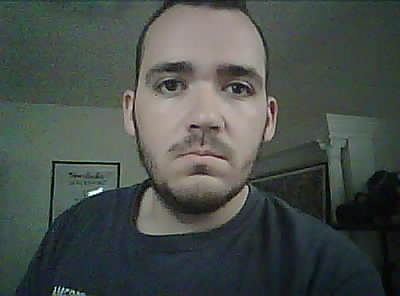

In [214]:
# test function on sample image from Images folder
with open('Images/straight.txt', 'r') as file:
    base64_image = file.read()
img = decode_image(base64_image)

#show the image
from IPython.display import display, Image as IPImage

ret, buffer = cv2.imencode('.png', img)
io_buf = io.BytesIO(buffer)
display(IPImage(io_buf.getvalue()))


Face detection function

In [200]:
# Function to detect face
def detect_face(image):
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x,y,w,h) in faces:
        face = image[y:y+h, x:x+w]
    return face

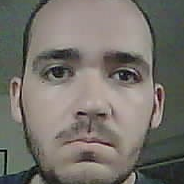

In [215]:
# Function to test and show detected face
face_img = detect_face(img)

#show the image
ret, buffer = cv2.imencode('.png', face_img)
io_buf = io.BytesIO(buffer)
display(IPImage(io_buf.getvalue()))

Eye detection function

In [202]:
# function to detect eyes and cut out the eyebrows

def detect_eyes(face):
    eyes = eyes_cascade.detectMultiScale(face) #, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    detected_eyes = []
    for (ex,ey,ew,eh) in eyes:
       # cut out the top 25% of the eye rectangle to remove the eyebrow
       ey = int(ey + 0.25*eh)
       eh = int(eh - 0.25*eh)
       eye = face[ey:ey+eh, ex:ex+ew]
       detected_eyes.append(eye)
    return detected_eyes

Eye 1:


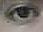

Eye 2:


In [216]:
# test function for eye detection on face

def display_detected_eyes(image):
    # Detect eyes
    eyes = detect_eyes(image)
    
    # For each detected eye
    for i, eye in enumerate(eyes):
        # If eye is detected
        if eye is not None:
            print(f"Eye {i+1}:")
            # Show the image
            ret, buffer = cv2.imencode('.png', eye)
            io_buf = io.BytesIO(buffer)
            display(IPImage(io_buf.getvalue()))
        else:
            print(f"Eye {i+1} not detected.")
            

# Display detected eyes
display_detected_eyes(face_img)


Eye image processing function

In [204]:
# Function to process eyes images
def process_eyes(eye):
    # Convert to grayscale
    gray_eye = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
    
    # Threshold the image
    _, thresh = cv2.threshold(gray_eye, 60, 255, cv2.THRESH_BINARY)
    
    # Erode and dilate to remove some noise
    kernel = np.ones((2,2),np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations = 2)
    thresh = cv2.dilate(thresh, kernel, iterations = 4)
    
    # Median blur to smooth image
    smooth_eye = cv2.medianBlur(thresh, 5)
    
    return smooth_eye


Processed Eye 1:


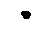

Processed Eye 2:


In [217]:
def display_processed_eyes(image):
    # Detect and process eyes
    eyes = detect_eyes(image)
    processed_eyes = [process_eyes(eye) for eye in eyes if eye is not None]
    
    # For each processed eye
    for i, eye in enumerate(processed_eyes):
        # If eye was processed
        if eye is not None:
            print(f"Processed Eye {i+1}:")
            # Show the image
            ret, buffer = cv2.imencode('.png', eye)
            io_buf = io.BytesIO(buffer)
            display(IPImage(io_buf.getvalue()))
        else:
            print(f"Processed Eye {i+1} not detected.")

# Display processed eyes
display_processed_eyes(face_img)


Blob detection function

In [209]:
# Function to detect pupil using Blob detector
def detect_pupil(smooth_eye):
    # Setup SimpleBlobDetector parameters
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 10

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)

    keypoints = detector.detect(smooth_eye)

    # Get the coordinates of the blobs (pupils)
    points = [(int(k.pt[0]), int(k.pt[1])) for k in keypoints]

    return points

In [225]:
def display_detected_pupils(image):
    # Create a copy of the image to avoid modifying the original image
    image_copy = image.copy()

    # Detect face
    face_img = detect_face(image_copy)

    # Detect eyes
    eyes = detect_eyes(face_img)

    # Process eyes and detect pupils
    for i, eye in enumerate(eyes):
        processed_eye = process_eyes(eye)
        pupils = detect_pupil(processed_eye)

        # If pupil is detected
        if pupils is not None and len(pupils) > 0:
            # Draw blobs around pupils
            for pupil in pupils:
                if len(pupil) == 2:
                    x, y = pupil
                    center = (int(x), int(y))
                    cv2.circle(eye, center, 3, (0,255,0), 2)
            print(f"Pupils in Eye {i+1}:")
            # Show the image
            ret, buffer = cv2.imencode('.png', eye)
            io_buf = io.BytesIO(buffer)
            display(IPImage(io_buf.getvalue()))
        else:
            print(f"Pupil in Eye {i+1} not detected.")

# Display detected pupils
display_detected_pupils(face_img)


Pupils in Eye 1:


Pupils in Eye 2:


Function to return pupil direction

In [226]:
# Function to determine pupil direction
def pupil_direction(pupil, eye):
    mid_point = int(eye.shape[1] / 2)

    if abs(pupil[0] - mid_point) < 5:
        direction = 'center'
    elif pupil[0] - mid_point < 0:
        direction = 'left'
    else:
        direction = 'right'

    return direction

Test directions on each of the images and ensure proper functionality

In [227]:
def display_detected_pupils_directions(image):
    # Create a copy of the image to avoid modifying the original image
    image_copy = image.copy()

    # Detect face
    face_img = detect_face(image_copy)

    # Detect eyes
    eyes = detect_eyes(face_img)

    # Initialize a list to hold the pupil directions
    pupil_directions = []

    # Process eyes and detect pupils
    for i, eye in enumerate(eyes):
        processed_eye = process_eyes(eye)
        pupils = detect_pupil(processed_eye)

        # If a pupil is detected
        if pupils is not None and len(pupils) == 1:
            pupil = pupils[0]
            # Determine pupil direction
            direction = pupil_direction(pupil, eye)
            print(f"Eye {i+1}: Pupil is looking {direction}")

            # Add the pupil direction to the list
            pupil_directions.append(direction)

            # Draw blob around pupil
            x, y = pupil
            center = (int(x), int(y))
            cv2.circle(eye, center, 3, (0,255,0), 2)
            print(f"Pupil in Eye {i+1}:")
            # Show the image
            ret, buffer = cv2.imencode('.png', eye)
            io_buf = io.BytesIO(buffer)
            display(IPImage(io_buf.getvalue()))
        else:
            print(f"Pupil in Eye {i+1} not detected.")

    # Return the list of pupil directions
    return pupil_directions

# Display detected pupils
display_detected_pupils_directions(face_img)


Eye 1: Pupil is looking center
Pupil in Eye 1:


Eye 2: Pupil is looking center
Pupil in Eye 2:


['center', 'center']

Eye 1: Pupil is looking left
Pupil in Eye 1:


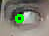

Eye 2: Pupil is looking left
Pupil in Eye 2:


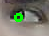

['left', 'left']

In [230]:
# Test pupil direction
# test function on sample image from Images folder
with open('Images/left.txt', 'r') as file:
    base64_image = file.read()
img2 = decode_image(base64_image)

# Function to test and show detected face
face_img2 = detect_face(img2)
display_detected_pupils_directions(face_img2)

Eye 1: Pupil is looking right
Pupil in Eye 1:


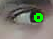

Eye 2: Pupil is looking right
Pupil in Eye 2:


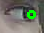

['right', 'right']

In [231]:
# Test pupil direction
# test function on sample image from Images folder
with open('Images/right.txt', 'r') as file:
    base64_image = file.read()
img2 = decode_image(base64_image)

# Function to test and show detected face
face_img2 = detect_face(img2)
display_detected_pupils_directions(face_img2)

#### Function putting all other functions together

In [232]:
def eye_tracker(image):
    # Create a copy of the image to avoid modifying the original image
    image_copy = image.copy()

    # Detect face
    face_img = detect_face(image_copy)

    # Detect eyes
    eyes = detect_eyes(face_img)

    # Initialize a list to hold the pupil directions
    pupil_directions = []

    # Process eyes and detect pupils
    for i, eye in enumerate(eyes):
        processed_eye = process_eyes(eye)
        pupils = detect_pupil(processed_eye)

        # If a pupil is detected
        if pupils is not None and len(pupils) == 1:
            pupil = pupils[0]
            # Determine pupil direction
            direction = pupil_direction(pupil, eye)
            print(f"Eye {i+1}: Pupil is looking {direction}")

            # Add the pupil direction to the list
            pupil_directions.append(direction)

        else:
            print(f"Pupil in Eye {i+1} not detected.")

    # Return the list of pupil directions
    return pupil_directions

In [233]:
# Test pupil direction
# test function on sample image from Images folder
with open('Images/right.txt', 'r') as file:
    base64_image = file.read()
img2 = decode_image(base64_image)

# Function to test and show detected face
face_img2 = detect_face(img2)
eye_tracker(face_img2)

Eye 1: Pupil is looking right
Eye 2: Pupil is looking right


['right', 'right']